In [44]:
import pandas as pd
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
import numpy as np
from lifelines import KaplanMeierFitter

In [45]:
df = pd.read_csv('relations_minified_versioning.csv')

## Data Preprocessing
df['is_out_of_date'] = df['is_out_of_date'].map({'t': True, 'f': False})
df['is_exposed'] = df['is_exposed'].map({'t': True, 'f': False})
df['interval_start_days'] = pd.to_numeric(df['interval_start_days'], errors='coerce')
df = df.dropna(subset=['interval_start_days'])
df['interval_end_days'] = pd.to_numeric(df['interval_end_days'], errors='coerce') ##coerce the errors to drop /N (NA) value in data
df = df.dropna(subset=['interval_end_days'])

df.dtypes

df.head

df.requirement_type.unique()

array(['floating - minor', 'floating - major', 'pinned', 'other',
       'floating - patch', 'floating - major - restrictive'], dtype=object)

In [46]:
# Sorting has effect on the model since the model expects the data for each individual together
df.sort_values(by=['dependency_id', 'interval_start_days', 'interval_end_days'], inplace=True)
print(df)
print(df.requirement_type.unique())

         dependency_id  interval_start_days  interval_end_days  \
617666              14                    0                1.0   
617667              14                    1                2.0   
617671              14                    2                5.0   
617669              14                    5                5.0   
617660              14                    5               10.0   
...                ...                  ...                ...   
1563925        1651060                    0              259.0   
1563908        1651061                    0               28.0   
1563921        1651062                    0               16.0   
1362810        1651063                    0              141.0   
1563920        1651064                    0                6.0   

         requirement_type  is_out_of_date  is_exposed  
617666             pinned            True       False  
617667             pinned            True       False  
617671             pinned            Tr

## Visualizing the Dependency Requirement Types

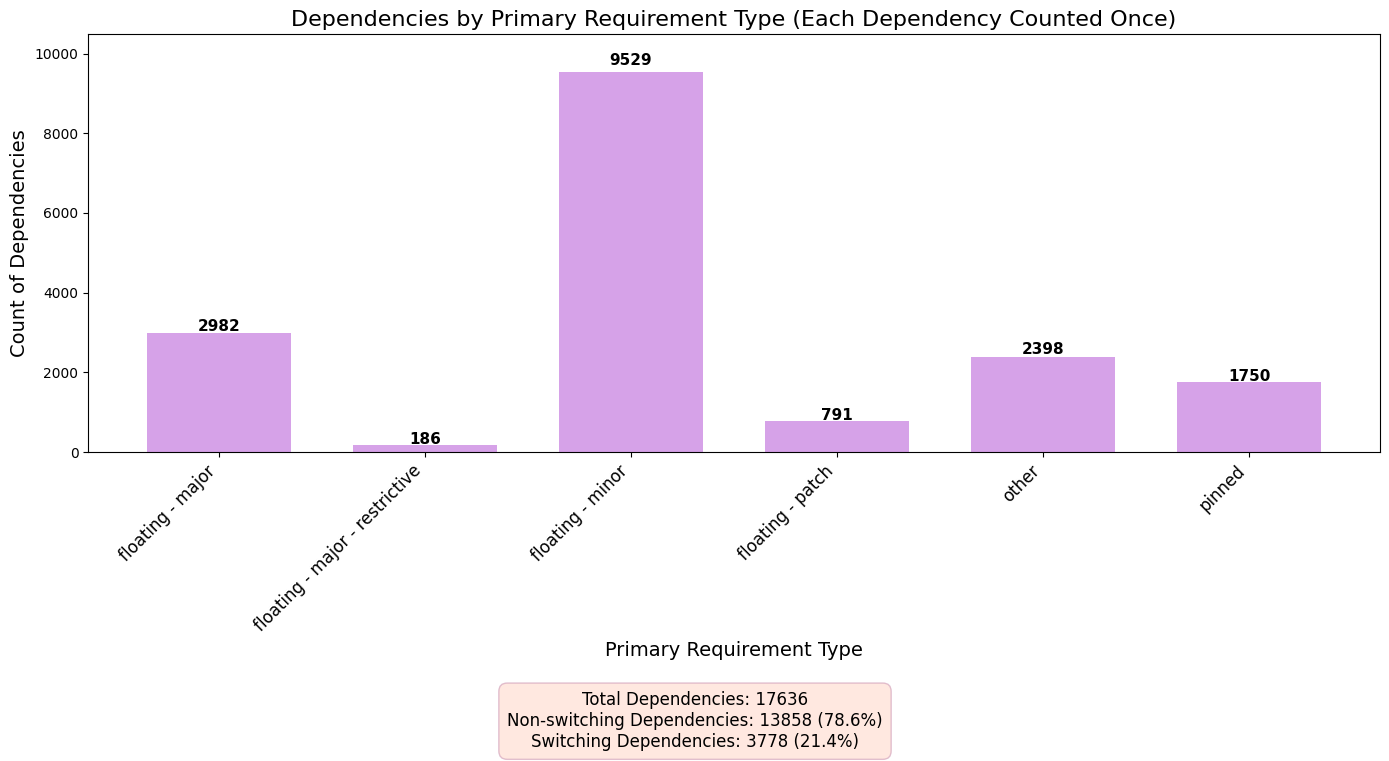

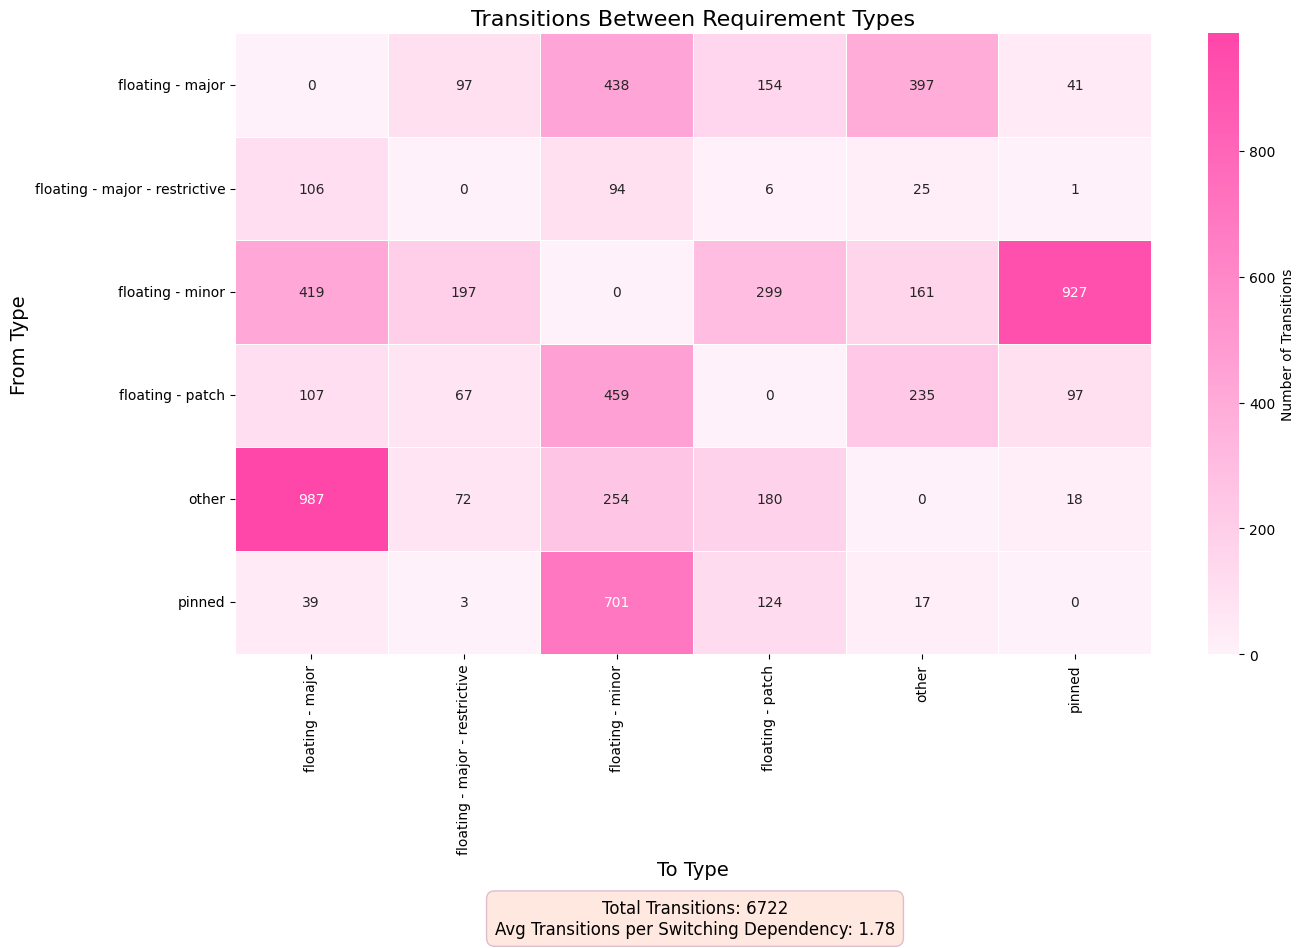

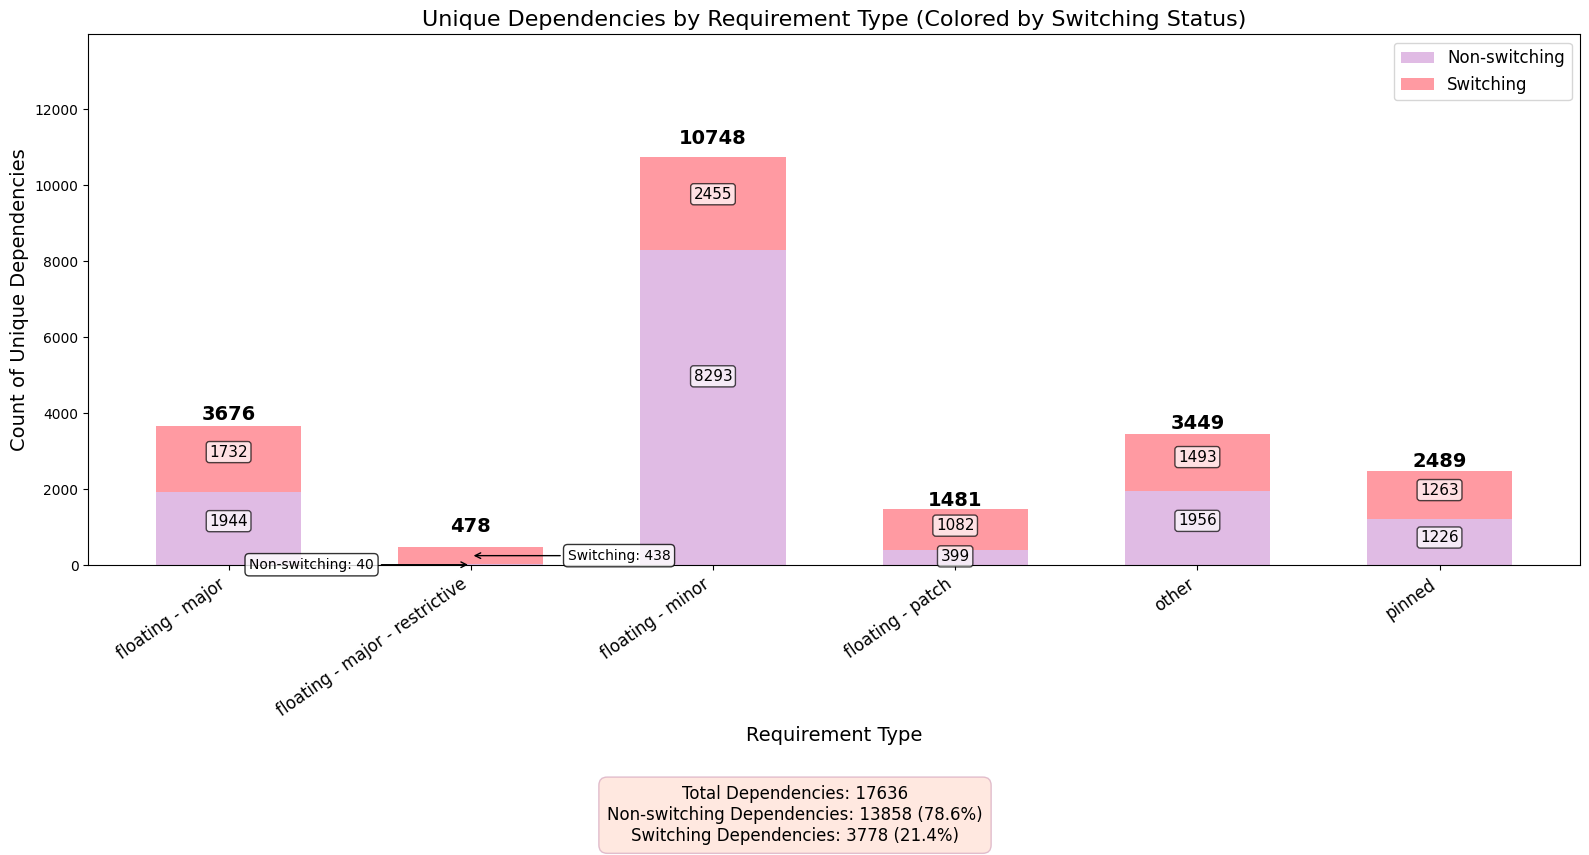

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

# Assuming df is already loaded with your data

# Part 1: Find dependencies that switch between requirement types
# Group by dependency_id and count unique requirement types
dependency_switches = df.groupby('dependency_id')['requirement_type'].nunique()
# Filter for dependencies with more than 1 requirement type
switching_deps = dependency_switches[dependency_switches > 1]
non_switching_deps = dependency_switches[dependency_switches == 1]

# Get the primary requirement type for each dependency (most common or first)
# For exclusive counts, we'll use the most frequent requirement type for each dependency
req_type_by_dep = df.groupby(['dependency_id', 'requirement_type']).size().reset_index(name='count')
primary_req_type = req_type_by_dep.sort_values(['dependency_id', 'count'], ascending=[True, False]) \
                                 .drop_duplicates('dependency_id')

# Count dependencies by their primary requirement type
exclusive_counts = primary_req_type.groupby('requirement_type').size()

# Create a DataFrame to track switching patterns
switching_patterns = pd.DataFrame(columns=['dependency_id', 'from_type', 'to_type', 'count'])

# For each switching dependency, find the transition patterns
rows = []
for dep_id in switching_deps.index:
    dep_data = df[df['dependency_id'] == dep_id]
    # Get the sequence of requirement types for this dependency
    req_sequence = dep_data['requirement_type'].tolist()
    
    # Track transitions between consecutive requirement types
    for i in range(len(req_sequence) - 1):
        from_type = req_sequence[i]
        to_type = req_sequence[i + 1]
        if from_type != to_type:  # Only count actual transitions
            rows.append({
                'dependency_id': dep_id,
                'from_type': from_type,
                'to_type': to_type,
                'count': 1
            })

if rows:
    switching_patterns = pd.DataFrame(rows)
    # Aggregate counts for same type transitions
    switching_patterns = switching_patterns.groupby(['from_type', 'to_type']).sum().reset_index()

# PLOT 1: Exclusive counts (each dependency counted only once)
plt.figure(figsize=(14, 8))

# Create a pretty pink color palette
exclusive_color = '#D6A2E8'  # Light purple

bars = plt.bar(exclusive_counts.index, exclusive_counts.values, color=exclusive_color, width=0.7)

plt.title('Dependencies by Primary Requirement Type (Each Dependency Counted Once)', fontsize=16)
plt.xlabel('Primary Requirement Type', fontsize=14)
plt.ylabel('Count of Dependencies', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, max(exclusive_counts.values) * 1.1)  # Add more space at the top

# Add the count values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (height * 0.02) + 5,
            f'{int(height)}', ha='center', fontsize=11, fontweight='bold')

# Add information about switching dependencies
plt.figtext(0.5, 0.01, 
            f'Total Dependencies: {len(dependency_switches)}\n'
            f'Non-switching Dependencies: {len(non_switching_deps)} ({len(non_switching_deps)/len(dependency_switches)*100:.1f}%)\n'
            f'Switching Dependencies: {len(switching_deps)} ({len(switching_deps)/len(dependency_switches)*100:.1f}%)', 
            ha='center', fontsize=12, bbox=dict(facecolor='#FFDFD3', alpha=0.7, boxstyle='round,pad=0.5', edgecolor='#D5A6BD'))

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

# PLOT 2: Transitions between requirement types with colored segments
if rows:
    # Create a pivot table for the heatmap
    pivot_data = switching_patterns.pivot_table(
        index='from_type', 
        columns='to_type', 
        values='count', 
        fill_value=0
    )
    
    plt.figure(figsize=(14, 10))
    
    # Custom pink colormap
    colors = ["#FFF1F9", "#FFDBEF", "#FFC6E5", "#FFB0DB", "#FF9AD1", "#FF85C7", "#FF70BD", "#FF5BB3", "#FF46A9"]
    cmap = LinearSegmentedColormap.from_list("pretty_pinks", colors)
    
    # Plot the heatmap with improved annotations
    ax = sns.heatmap(pivot_data, annot=True, cmap=cmap, fmt='g', linewidths=0.5,
                cbar_kws={'label': 'Number of Transitions'})
    
    # Improve the appearance
    plt.title('Transitions Between Requirement Types', fontsize=16)
    plt.xlabel('To Type', fontsize=14)
    plt.ylabel('From Type', fontsize=14)
    
    # Add legend for switching dependencies with prettier box
    total_transitions = switching_patterns['count'].sum()
    plt.figtext(0.5, 0.01, 
                f'Total Transitions: {total_transitions}\n'
                f'Avg Transitions per Switching Dependency: {total_transitions/len(switching_deps):.2f}', 
                ha='center', fontsize=12, bbox=dict(facecolor='#FFDFD3', alpha=0.7, boxstyle='round,pad=0.5', edgecolor='#D5A6BD'))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# PLOT 3: Requirement type distribution colored by switching vs non-switching
# Get counts by requirement type for switching and non-switching dependencies
switching_ids = switching_deps.index.tolist()

# Create a new dataframe with dependency_id and switching status
dep_status = pd.DataFrame({
    'dependency_id': dependency_switches.index,
    'is_switching': [dep_id in switching_ids for dep_id in dependency_switches.index]
})

# Merge with the original data
df_with_status = pd.merge(df, dep_status, on='dependency_id')

# Now count unique dependencies by requirement type and switching status
switching_status_counts = df_with_status.drop_duplicates(['dependency_id', 'requirement_type']) \
                                       .groupby(['requirement_type', 'is_switching']).size() \
                                       .unstack(fill_value=0)

# Reset index to make requirement_type a column
if isinstance(switching_status_counts, pd.Series):
    # Handle case where only one switching status exists
    switching_status_counts = pd.DataFrame(switching_status_counts)
else:
    switching_status_counts = switching_status_counts.reset_index()

# Rename columns for clarity
if True in switching_status_counts.columns:
    switching_status_counts = switching_status_counts.rename(columns={True: 'Switching', False: 'Non-switching'})
elif 'is_switching' in switching_status_counts.columns:
    switching_status_counts = switching_status_counts.rename(columns={'is_switching': 'Switching'})
    switching_status_counts['Non-switching'] = 0

# Fill NaN with zeros
switching_status_counts = switching_status_counts.fillna(0)

# Create the stacked bar chart
plt.figure(figsize=(16, 9))
width = 0.6  # Narrower bars for more space between them

# Create a pretty pink color palette
non_switching_color = '#E0BBE4'  # Light lavender
switching_color = '#FF9AA2'     # Light pink

# Get the requirement types and values
if 'requirement_type' in switching_status_counts.columns:
    req_types = switching_status_counts['requirement_type']
    non_switching_values = switching_status_counts['Non-switching'] if 'Non-switching' in switching_status_counts.columns else 0
    switching_values = switching_status_counts['Switching'] if 'Switching' in switching_status_counts.columns else 0
else:
    # Handle multiindex case
    req_types = switching_status_counts.index
    non_switching_values = switching_status_counts[False] if False in switching_status_counts.columns else 0
    switching_values = switching_status_counts[True] if True in switching_status_counts.columns else 0

# Draw the stacked bars
plt.bar(req_types, non_switching_values, width, label='Non-switching', color=non_switching_color)
plt.bar(req_types, switching_values, width, bottom=non_switching_values, label='Switching', color=switching_color)

# Create custom annotations
for i, req_type in enumerate(req_types):
    non_switch = non_switching_values.iloc[i] if hasattr(non_switching_values, 'iloc') else non_switching_values[i]
    switch = switching_values.iloc[i] if hasattr(switching_values, 'iloc') else switching_values[i]
    total = non_switch + switch
    
    # Special handling for the problematic bar (floating-major-restrictive)
    if 'restrictive' in str(req_type):
        # Place the total high above
        plt.text(i, total + 400, f'{int(total)}', ha='center', fontsize=14, fontweight='bold')
        
###############################################################  
# editing the spacing around the arrows       
        # Create annotation arrows for the segments to make them clear
        # For non-switching segment
        if non_switch > 0:
            # Place an annotation outside the bar with an arrow pointing to the segment
            plt.annotate(
                f'Non-switching: {int(non_switch)}',
                xy=(i, non_switch/2),  # Point in the middle of the segment
                xytext=(i - 0.4, non_switch/2),  # Text position 
                arrowprops=dict(arrowstyle="->", color='black'),
                fontsize=10,
                ha='right',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', alpha=0.8)
            )
        
        # For switching segment
        if switch > 0:
            # Place an annotation outside the bar with an arrow pointing to the segment
            plt.annotate(
                f'Switching: {int(switch)}',
                xy=(i, non_switch + switch/2),  # Point in the middle of the segment
                xytext=(i + 0.4, non_switch + switch/2),  # Text position
                arrowprops=dict(arrowstyle="->", color='black'),
                fontsize=10,
                ha='left',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', alpha=0.8)
            )

###############################################################  
    else:
        # Regular bars - place total above
        plt.text(i, total + (total * 0.03) + 30, f'{int(total)}', ha='center', fontsize=14, fontweight='bold')
        
        # Add counts in the middle of each segment if large enough
        if non_switch > total * 0.08:
            plt.text(i, non_switch * 0.6, f'{int(non_switch)}', ha='center', va='center', 
                     fontsize=11, color='black', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))
        
        if switch > total * 0.08:
            plt.text(i, non_switch + switch * 0.6, f'{int(switch)}', ha='center', va='center', 
                     fontsize=11, color='black', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

plt.title('Unique Dependencies by Requirement Type (Colored by Switching Status)', fontsize=16)
plt.xlabel('Requirement Type', fontsize=14)
plt.ylabel('Count of Unique Dependencies', fontsize=14)
plt.xticks(rotation=35, ha='right', fontsize=12)
plt.ylim(0, max(non_switching_values + switching_values) * 1.3)  # Extra space for annotations

plt.legend(fontsize=12, loc='upper right')

# Add information about switching dependencies with a prettier box
plt.figtext(0.5, 0.01, 
            f'Total Dependencies: {len(dependency_switches)}\n'
            f'Non-switching Dependencies: {len(non_switching_deps)} ({len(non_switching_deps)/len(dependency_switches)*100:.1f}%)\n'
            f'Switching Dependencies: {len(switching_deps)} ({len(switching_deps)/len(dependency_switches)*100:.1f}%)', 
            ha='center', fontsize=12, bbox=dict(facecolor='#FFDFD3', alpha=0.7, boxstyle='round,pad=0.5', edgecolor='#D5A6BD'))

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

## Cox Proportional Hazards Model
The first step is to remove the dependencies that transition between requirement types. Modeling dependencies that transition between requirement types causes the covariates to become 'time varying' and violate the proportional hazard assumption. When the proportional hazard 

In [49]:
## what if we remove the switching dependencies from the data set
df_no_switching = df[~df['dependency_id'].isin(switching_deps.index)]
df_no_switching = df_no_switching.drop_duplicates(['dependency_id', 'requirement_type'])

print("Number of unique dependencies that do not transition between requirement types: ",df_no_switching['dependency_id'].nunique())


Number of unique dependencies that do not transition between requirement types:  13858


In [50]:
# Need to convert the requirement_type column to a categorical type
df_no_switching['requirement_type'] = pd.Categorical(
    df_no_switching['requirement_type'],
    categories=[
        'floating - major', # This is the baseline category for one-hot encoding
        'floating - major - restrictive',
        'floating - minor',
        'floating - patch',
        'pinned',
        'other'
    ],
    ordered=True
)
df_no_switching_copy = pd.get_dummies(df_no_switching, columns=['requirement_type'], drop_first=True)
df_no_switching_copy.head

<bound method NDFrame.head of          dependency_id  interval_start_days  interval_end_days  \
1562167             91                    0                2.0   
1086745            313                    0                4.0   
1082554            483                    0                0.0   
555783            1996                    0                4.0   
1119397           3701                    0                0.0   
...                ...                  ...                ...   
1563925        1651060                    0              259.0   
1563908        1651061                    0               28.0   
1563921        1651062                    0               16.0   
1362810        1651063                    0              141.0   
1563920        1651064                    0                6.0   

         is_out_of_date  is_exposed  \
1562167           False       False   
1086745           False       False   
1082554           False       False   
555783            Fal

# Cox Proportional Hazard Models
In order to use the Cox Proportional Hazard model, we must have only one row of data per dependency. 

In [69]:
df_single_row = (
    df_no_switching_copy
    .sort_values("interval_end_days")  # Optional: ensure right ordering
    .groupby("dependency_id")
    .last()  # Or first(), depending on your design
    .reset_index()
)

print("Number of unique dependencies: ",df_single_row['dependency_id'].nunique())
print("Number of rows of data: ",df_single_row.shape[0])
print("We verified that each dependency_id has only one row of data: ",df_single_row['dependency_id'].nunique() == df_single_row.shape[0])

df_single_row.head

Number of unique dependencies:  13858
Number of rows of data:  13858
We verified that each dependency_id has only one row of data:  True


<bound method NDFrame.head of        dependency_id  interval_start_days  interval_end_days  is_out_of_date  \
0                 91                    0                2.0           False   
1                313                    0                4.0           False   
2                483                    0                0.0           False   
3               1996                    0                4.0           False   
4               3701                    0                0.0           False   
...              ...                  ...                ...             ...   
13853        1651060                    0              259.0           False   
13854        1651061                    0               28.0           False   
13855        1651062                    0               16.0           False   
13856        1651063                    0              141.0           False   
13857        1651064                    0                6.0           False   

       is

In [83]:
df_single_row_outdated = (
    df_no_switching_copy
    .groupby("dependency_id")
    .agg({
        "interval_end_days": "max",  # total observed time
        "is_out_of_date": "max",     # True if event ever occurred
        "requirement_type_floating - major - restrictive": "first",
        "requirement_type_floating - minor": "first",
        "requirement_type_floating - patch": "first",
        "requirement_type_pinned": "first",
        "requirement_type_other": "first"
    })
    .reset_index()
)

df_single_row_outdated.head


<bound method NDFrame.head of        dependency_id  interval_end_days  is_out_of_date  \
0                 91                2.0           False   
1                313                4.0           False   
2                483                0.0           False   
3               1996                4.0           False   
4               3701                0.0           False   
...              ...                ...             ...   
13853        1651060              259.0           False   
13854        1651061               28.0           False   
13855        1651062               16.0           False   
13856        1651063              141.0           False   
13857        1651064                6.0           False   

       requirement_type_floating - major - restrictive  \
0                                                False   
1                                                False   
2                                                False   
3                            

In [89]:
df_single_row_vulnerable = (
    df_no_switching_copy
    .groupby("dependency_id")
    .agg({
        "interval_end_days": "max",  # total observed time
        "is_exposed": "max",     # True if event ever occurred
        "requirement_type_floating - major - restrictive": "first",
        "requirement_type_floating - minor": "first",
        "requirement_type_floating - patch": "first",
        "requirement_type_pinned": "first",
        "requirement_type_other": "first"
    })
    .reset_index()
)

df_single_row_vulnerable.head


<bound method NDFrame.head of        dependency_id  interval_end_days  is_exposed  \
0                 91                2.0       False   
1                313                4.0       False   
2                483                0.0       False   
3               1996                4.0       False   
4               3701                0.0       False   
...              ...                ...         ...   
13853        1651060              259.0       False   
13854        1651061               28.0       False   
13855        1651062               16.0       False   
13856        1651063              141.0       False   
13857        1651064                6.0       False   

       requirement_type_floating - major - restrictive  \
0                                                False   
1                                                False   
2                                                False   
3                                                False   
4                  

In [85]:
## making sure the data is correct 

# Check if any dependency has more than one requirement type marked True
multi_type = (
    df_single_row_outdated
    .groupby("dependency_id")[
        [
            "requirement_type_floating - major - restrictive",
            "requirement_type_floating - minor",
            "requirement_type_floating - patch",
            "requirement_type_pinned",
            "requirement_type_other"
        ]
    ]
    .nunique()
    .gt(1)
    .any(axis=1)
)

df_single_row_outdated[df_single_row_outdated["dependency_id"].isin(multi_type[multi_type].index)]


,dependency_id,interval_end_days,is_out_of_date,requirement_type_floating - major - restrictive,requirement_type_floating - minor,requirement_type_floating - patch,requirement_type_pinned,requirement_type_other


In [84]:
## Another Sanity Check

df_single_row_outdated[df_single_row_outdated["dependency_id"] == 1996]

,dependency_id,interval_end_days,is_out_of_date,requirement_type_floating - major - restrictive,requirement_type_floating - minor,requirement_type_floating - patch,requirement_type_pinned,requirement_type_other
3,1996,4.0,False,False,True,False,False,False


In [86]:
df_single_row_outdated[df_single_row_outdated["dependency_id"] == 1996][[
    "requirement_type_floating - major - restrictive",
    "requirement_type_floating - minor",
    "requirement_type_floating - patch",
    "requirement_type_pinned",
    "requirement_type_other"
]].drop_duplicates()

,requirement_type_floating - major - restrictive,requirement_type_floating - minor,requirement_type_floating - patch,requirement_type_pinned,requirement_type_other
3,False,True,False,False,False


In [87]:
df_single_row_outdated.columns

Index(['dependency_id', 'interval_end_days', 'is_out_of_date',
       'requirement_type_floating - major - restrictive',
       'requirement_type_floating - minor',
       'requirement_type_floating - patch', 'requirement_type_pinned',
       'requirement_type_other'],
      dtype='object')

## Cox Proportional Hazard Model - Outdated Dependencies

<lifelines.CoxPHFitter: fitted with 13858 total observations, 12932 right-censored observations>
             duration col = 'interval_end_days'
                event col = 'is_out_of_date'
      baseline estimation = breslow
   number of observations = 13858
number of events observed = 926
   partial log-likelihood = -7933.60
         time fit was run = 2025-05-05 02:02:24 UTC

---
                                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                        
requirement_type_floating - major - restrictive  1.71      5.51      1.05           -0.36            3.77                0.70               43.50
requirement_type_floating - minor                2.55     12.77      0.34            1.89            3.21                6.60               24.70
requirement_type_floating - patch                3.86     47.56      0.35            3.17            4.55               23.81               95.02
requirement_type_pinned                          4.14     62.54      0.34            3.47            4.80               32.08              121.91
requirement_type_other                           2.91     18.45      0.34            2.24            3.58                9.44               36.05

                                                 cmp to     z      p  -log2(p)
covariate                                                                     
requirement_type_floating - major - restrictive    0.00  1.62   0.11      3.25
requirement_type_floating - minor                  0.00  7.56 <0.005     44.55
requirement_type_floating - patch                  0.00 10.94 <0.005     90.08
requirement_type_pinned                            0.00 12.14 <0.005    110.31
requirement_type_other                             0.00  8.53 <0.005     55.88
---
Concordance = 0.68
Partial AIC = 15877.19
log-likelihood ratio test = 573.83 on 5 df
-log2(p) of ll-ratio test = 402.09

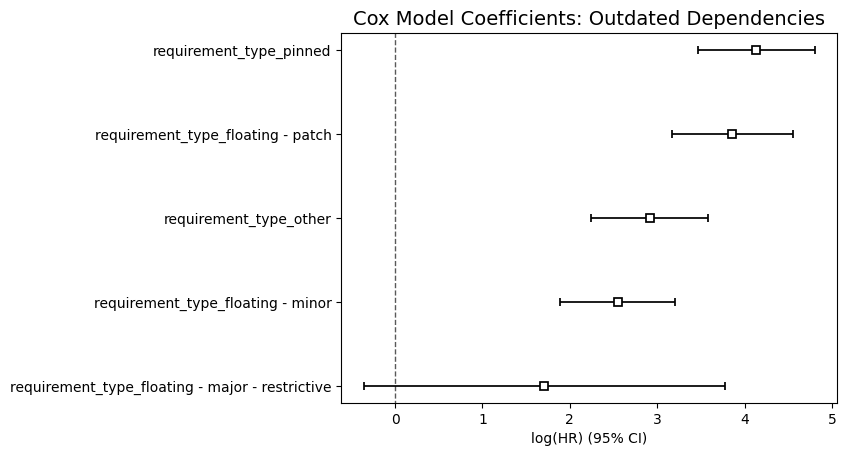

In [91]:
df_model = df_single_row_outdated.drop(columns=["dependency_id"])

cph = CoxPHFitter()
cph.fit(df_model, duration_col='interval_end_days', event_col='is_out_of_date')

cph.print_summary()  # access the individual results using cph.summary

# Plot and set title
ax = cph.plot()
ax.set_title("Cox Model Coefficients: Outdated Dependencies", fontsize=14)
plt.show()

### Interpretation 

*Please note that this interpretation came from AI and we should rephrase before publishing. 

## 📊 Cox Proportional Hazards Model Interpretation (Time-Fixed)

**Model Info:**
- `duration_col`: `interval_end_days`
- `event_col`: `is_out_of_date`
- Observations: **13,858**
- Events: **926**
- Concordance Index: **0.70**
- Partial Log-Likelihood: **-7927.89**
- Partial AIC: **15867.77**
- Log-likelihood Ratio Test: **585.25 on 6 df (p < 0.005)**

---

### 🔍 Key Results

| Requirement Type                      | Coef | Exp(Coef) | 95% CI (Exp(Coef))     | z     | p-value | Interpretation                                    |
|--------------------------------------|------|-----------|-------------------------|-------|---------|--------------------------------------------------|
| Floating - Major - Restrictive       | 1.71 | 5.51      | [0.70, 43.50]           | 1.62  | 0.11    | Large HR, but not statistically significant.     |
| Floating - Minor                     | 2.55 | 12.77     | [6.60, 24.70]           | 7.56  | <0.005  | Strong, statistically significant effect.        |
| Floating - Patch                     | 3.86 | 47.56     | [23.81, 95.02]          | 10.94 | <0.005  | Very strong effect on hazard.                    |
| Pinned                               | 4.14 | 62.54     | [32.08, 121.91]         | 12.14 | <0.005  | Strongest effect; highest hazard increase.       |
| Other                                | 2.91 | 18.45     | [9.44, 36.05]           | 8.53  | <0.005  | High hazard, significant increase in risk.       |

---

### ✅ Summary

- The baseline (reference) group is dependencies with no requirement type flag set.
- All requirement types except 'Floating - Major - Restrictive' are statistically significant.
- 'Pinned' and 'Floating - Patch' have the highest hazard ratios, indicating they are most strongly associated with an increased risk of becoming out-of-date.
- 'Floating - Major - Restrictive' has a large HR (~5.5) but is not statistically significant (likely due to wide CI or low support).


In [92]:
#  Checking the proportional hazards assumption
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, df_model, time_transform='rank')
print(results.summary)

                                                 test_statistic         p  \
requirement_type_floating - major - restrictive        1.258733  0.261891   
requirement_type_floating - minor                      1.575652  0.209388   
requirement_type_floating - patch                      0.759952  0.383343   
requirement_type_other                                 0.191200  0.661919   
requirement_type_pinned                                2.361011  0.124402   

                                                 -log2(p)  
requirement_type_floating - major - restrictive  1.932962  
requirement_type_floating - minor                2.255749  
requirement_type_floating - patch                1.383290  
requirement_type_other                           0.595273  
requirement_type_pinned                          3.006924  


### The model passes the cox proportional hazards assumption. 

## **Cox Proportional Hazards Model - Time Varying Covariates**


In [56]:
df = pd.read_csv('relations_minified_versioning.csv')

## Data Preprocessing
df['is_out_of_date'] = df['is_out_of_date'].map({'t': True, 'f': False})
df['is_exposed'] = df['is_exposed'].map({'t': True, 'f': False})
df['interval_start_days'] = pd.to_numeric(df['interval_start_days'], errors='coerce')
df = df.dropna(subset=['interval_start_days'])
df['interval_end_days'] = pd.to_numeric(df['interval_end_days'], errors='coerce') ##coerce the errors to drop /N (NA) value in data
df = df.dropna(subset=['interval_end_days'])

## must remove deependencies that have the start and end dates the same
df = df[df['interval_start_days'] != df['interval_end_days']]

df.dtypes

df.head

df.requirement_type.unique()

array(['floating - minor', 'floating - major', 'pinned', 'other',
       'floating - patch', 'floating - major - restrictive'], dtype=object)

In [57]:
# Need to convert the requirement_type column to a categorical type

df['requirement_type'] = pd.Categorical(
    df['requirement_type'],
    categories=[
        'floating - major', # This is the baseline category for one-hot encoding
        'floating - major - restrictive',
        'floating - minor',
        'floating - patch',
        'pinned',
        'other'
    ],
    ordered=True
)
df = pd.get_dummies(df, columns=['requirement_type'], drop_first=True)

# Sorting has effect on the model since the model expects the data for each individual together
df.sort_values(by=['dependency_id', 'interval_start_days', 'interval_end_days'], inplace=True)

In [58]:
df.dtypes

dependency_id                                        int64
interval_start_days                                  int64
interval_end_days                                  float64
is_out_of_date                                        bool
is_exposed                                            bool
requirement_type_floating - major - restrictive       bool
requirement_type_floating - minor                     bool
requirement_type_floating - patch                     bool
requirement_type_pinned                               bool
requirement_type_other                                bool
dtype: object

## Cox Proportional Hazards Model - Outdated Dependencies

In [93]:
## only keep the variables we are interested in modeling 
columns_to_keep = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_out_of_date', 'requirement_type_floating - major - restrictive', 'requirement_type_floating - minor', 'requirement_type_floating - patch', 'requirement_type_pinned', 'requirement_type_other']
df_model_outdated = df[columns_to_keep]
df_model_outdated.head

<bound method NDFrame.head of          dependency_id  interval_start_days  interval_end_days  \
617666              14                    0                1.0   
617667              14                    1                2.0   
617671              14                    2                5.0   
617660              14                    5               10.0   
617668              14                   10               23.0   
...                ...                  ...                ...   
1563925        1651060                    0              259.0   
1563908        1651061                    0               28.0   
1563921        1651062                    0               16.0   
1362810        1651063                    0              141.0   
1563920        1651064                    0                6.0   

         is_out_of_date  requirement_type_floating - major - restrictive  \
617666             True                                            False   
617667             True  

In [94]:
# verifying we kept the proper number of unique dependencies
print("Number of unique dependencies: ",df_model_outdated['dependency_id'].nunique())

Number of unique dependencies:  17504


<lifelines.CoxTimeVaryingFitter: fitted with 1287462 periods, 17504 subjects, 219692 events>
         event col = 'is_out_of_date'
number of subjects = 17504
 number of periods = 1287462
  number of events = 219692
partial log-likelihood = -1912547.64
  time fit was run = 2025-05-05 02:08:57 UTC

---
                                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                        
requirement_type_floating - major - restrictive  3.68     39.64      0.03            3.61            3.75               37.02               42.44
requirement_type_floating - minor                3.64     38.18      0.03            3.58            3.70               36.03               40.46
requirement_type_floating - patch                4.18     65.14      0.03            4.12            4.24               61.39               69.13
requirement_type_pinned                          4.51     91.24      0.03            4.46            4.57               86.07               96.73
requirement_type_other                           3.18     24.12      0.03            3.12            3.24               22.72               25.60

                                                 cmp to      z      p  -log2(p)
covariate                                                                      
requirement_type_floating - major - restrictive    0.00 105.63 <0.005       inf
requirement_type_floating - minor                  0.00 122.92 <0.005       inf
requirement_type_floating - patch                  0.00 137.96 <0.005       inf
requirement_type_pinned                            0.00 151.46 <0.005       inf
requirement_type_other                             0.00 104.51 <0.005       inf
---
Partial AIC = 3825105.28
log-likelihood ratio test = 117458.66 on 5 df
-log2(p) of ll-ratio test = inf

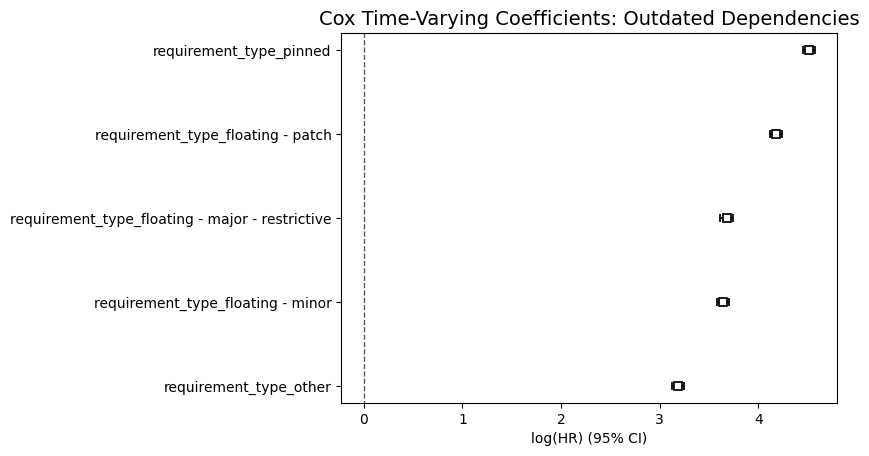

In [95]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter()
ctv.fit(df_model_outdated, id_col="dependency_id", event_col="is_out_of_date", start_col="interval_start_days", stop_col="interval_end_days")
ctv.print_summary()

# Plot and set title
ax = ctv.plot()
ax.set_title("Cox Time-Varying Coefficients: Outdated Dependencies", fontsize=14)
plt.show()

# Interpretation

*Please note that this interpretation came from AI and we need to rephrase in our words before publishing*

This Cox proportional hazards model examines when software dependencies become outdated, with 17,504 subjects and over 1.2 million observation periods. The outcome "is_out_of_date" indicates when dependencies become outdated.

### Note on hazard ratio:
Values > 1: higher risk of the event (becoming out-of-date).

**Example:** At any given time, if a dependency is currently under a `"pinned"` requirement, its hazard of becoming out-of-date is approximately **91× higher** than the baseline.  
These hazard ratios represent the **relative risk at that time**, conditional on the dependency’s current requirement type.


### Hazard Ratios (exp(coef)) Compared to Baseline (requirement_type_floating - major)

*These hazard ratios come from a **Cox Time-Varying Proportional Hazards model**, where the **type of requirement can change over time**. The values below represent the **relative instantaneous risk** of a dependency becoming exposed **when it is in a given state**, compared to the baseline.*

requirement_type_floating - major - restrictive: 39.64 (3964% higher risk than baseline) 

requirement_type_floating - minor: 38.18 (3718% higher risk)  

requirement_type_floating - patch: 65.14 (6414% higher risk)  

requirement_type_pinned: 91.24 (9024% higher risk)  

requirement_type_other: 24.12 (2312% higher risk) 

### Interpretation of Hazard Ratios
These extremely high hazard ratios indicate:

requirement_type_pinned has by far the highest risk, with dependencies nearly 91 times more likely to become outdated compared to floating major requirements.

requirement_type_floating - patch has the second-highest risk, with dependencies about 65 times more likely to become outdated.

requirement_type_floating - major - restrictive and requirement_type_floating - minor have similar elevated risks (about 39 and 38 times higher, respectively).

Even requirement_type_other shows a substantially higher risk (24 times) compared to the baseline.

Statistical Significance
All results are highly statistically significant (p < 0.005) with extremely large z-values (>100). The narrow confidence intervals indicate high precision in these estimates. The log-likelihood ratio test (117458.66 on 5 df) confirms the model as a whole is extremely significant.

### Practical Implications
These results strongly suggest that compared to floating major version requirements:

Pinned dependencies become outdated at a dramatically faster rate.
Patch-level floating dependencies also become outdated very quickly.
Restrictive major and minor floating dependencies have similar elevated risks.
The "other" category has a lower but still substantially elevated risk.

This suggests that if maintaining up-to-date dependencies is important, using floating major version requirements (the baseline) appears to be the optimal strategy, as all other requirement types show significantly higher risks of becoming outdated.


```text
Pinned                       | ████████████████████████████████████████████████████████████████████ (HR ≈ 91.24)
Floating - Patch             | ███████████████████████████████████████████████████ (HR ≈ 65.14)
Floating - Major - Restrict  | █████████████████████████████████████ (HR ≈ 39.64)
Floating - Minor             | ████████████████████████████████████ (HR ≈ 38.18)
Other                        | ████████████████████████ (HR ≈ 24.12)
```

## Cox Proportional Hazards Model - Vulnerable Dependencies

In [39]:
## only keep the variables we are interested in modeling 
columns_to_keep = ['dependency_id', 'interval_start_days', 'interval_end_days', 'is_exposed', 'requirement_type_floating - major - restrictive', 'requirement_type_floating - minor', 'requirement_type_floating - patch', 'requirement_type_pinned', 'requirement_type_other']
df_model_vulnerable = df[columns_to_keep]
df_model_vulnerable.head

<bound method NDFrame.head of          dependency_id  interval_start_days  interval_end_days  is_exposed  \
617666              14                    0                1.0       False   
617667              14                    1                2.0       False   
617671              14                    2                5.0       False   
617660              14                    5               10.0       False   
617668              14                   10               23.0       False   
...                ...                  ...                ...         ...   
1563925        1651060                    0              259.0       False   
1563908        1651061                    0               28.0       False   
1563921        1651062                    0               16.0       False   
1362810        1651063                    0              141.0       False   
1563920        1651064                    0                6.0       False   

         requirement_type_floatin

In [42]:
# verifying we kept the proper number of unique dependencies
print("Number of unique dependencies: ",df_model_vulnerable['dependency_id'].nunique())
print("Number of dependencies that are vulnerable: ",df_model_vulnerable['is_exposed'].sum())
print("Number of dependencies that are not vulnerable: ",df_model_vulnerable['is_exposed'].count() - df_model_vulnerable['is_exposed'].sum())

Number of unique dependencies:  17504
Number of dependencies that are vulnerable:  1931
Number of dependencies that are not vulnerable:  1285531


<lifelines.CoxTimeVaryingFitter: fitted with 1287462 periods, 17504 subjects, 1931 events>
         event col = 'is_exposed'
number of subjects = 17504
 number of periods = 1287462
  number of events = 1931
partial log-likelihood = -16624.52
  time fit was run = 2025-05-05 00:51:19 UTC

---
                                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                        
requirement_type_floating - major - restrictive  4.39     80.96      0.33            3.75            5.04               42.46              154.39
requirement_type_floating - minor                3.09     21.95      0.30            2.49            3.68               12.09               39.82
requirement_type_floating - patch                4.45     86.06      0.31            3.85            5.06               47.10              157.22
requirement_type_pinned                          4.22     68.09      0.31            3.62            4.82               37.40              123.95
requirement_type_other                           4.27     71.37      0.30            3.67            4.87               39.26              129.74

                                                 cmp to     z      p  -log2(p)
covariate                                                                     
requirement_type_floating - major - restrictive    0.00 13.34 <0.005    132.47
requirement_type_floating - minor                  0.00 10.16 <0.005     78.15
requirement_type_floating - patch                  0.00 14.49 <0.005    155.60
requirement_type_pinned                            0.00 13.81 <0.005    141.69
requirement_type_other                             0.00 14.00 <0.005    145.47
---
Partial AIC = 33259.05
log-likelihood ratio test = 1379.77 on 5 df
-log2(p) of ll-ratio test = 981.55

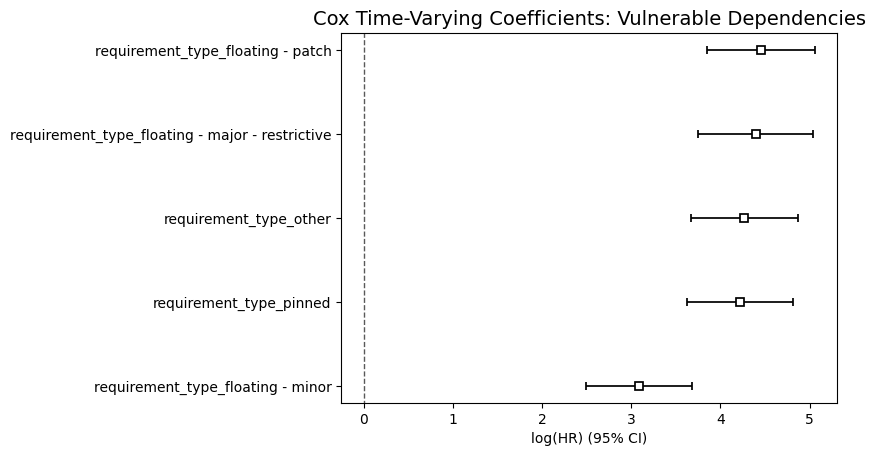

In [43]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter()
ctv.fit(df_model_vulnerable, id_col="dependency_id", event_col="is_exposed", start_col="interval_start_days", stop_col="interval_end_days")
ctv.print_summary()

# Plot and set title
ax = ctv.plot()
ax.set_title("Cox Time-Varying Coefficients: Vulnerable Dependencies", fontsize=14)
plt.show()

# Interpretation

*Please note that this interpretation came from AI and we need to rephrase in our words before publishing*


This Cox proportional hazards model examines when software dependencies become vulnerable, with 17,504 subjects and over 1.2 million observation periods. The outcome "is_exposed" indicates when dependencies become vulnerable.

### Note on hazard ratio:

Values > 1: higher risk of the event (becoming exposed).

**Example:** At any point in time, if a dependency's requirement type is `"floating - patch"`, its hazard of becoming exposed is approximately **86× higher** than the baseline.  
These ratios reflect the **instantaneous risk given the current state**, not a fixed risk across the entire timeline.


### Hazard Ratios (exp(coef)) Compared to Baseline (requirement_type_floating - major)

*These hazard ratios come from a **Cox Time-Varying Proportional Hazards model**, where the **type of requirement can change over time**. The values below represent the **relative instantaneous risk** of a dependency becoming exposed **when it is in a given state**, compared to the baseline.*

requirement_type_floating - major - restrictive: 80.96 (7996% higher risk than baseline)

requirement_type_floating - minor: 21.95 (2095% higher risk)

requirement_type_floating - patch: 86.06 (8506% higher risk)

requirement_type_pinned: 68.09 (6709% higher risk)

requirement_type_other: 71.37 (7037% higher risk)

### Interpretation of Hazard Ratios
These extremely high hazard ratios indicate:

requirement_type_floating - patch has the highest risk, with dependencies about 86 times more likely to become exposed compared to floating major requirements.

requirement_type_floating - major - restrictive has the second-highest risk, with dependencies about 81 times more likely to become exposed.

requirement_type_other and requirement_type_pinned have similarly high risks (about 71 and 68 times higher, respectively).

requirement_type_floating - minor shows a relatively lower but still substantial risk (22 times) compared to the baseline.

### Statistical Significance
All results are highly statistically significant (p < 0.005) with large z-values (>10). The log-likelihood ratio test (1379.77 on 5 df) confirms the model as a whole is extremely significant, with a -log2(p) value of 981.55.

### Practical Implications
These results strongly suggest that compared to floating major version requirements:

Patch-level floating dependencies become exposed at a dramatically faster rate.
Restrictive major dependencies also become exposed very quickly.
Other requirement types and pinned dependencies have similarly high exposure risks.
Minor floating dependencies have a lower but still substantially elevated risk.

This suggests that if minimizing security exposure risk is important, using floating major version requirements (the baseline) appears to be the optimal strategy, as all other requirement types show significantly higher risks of becoming exposed.

```text
Floating - Patch               | █████████████████████████████████████████████████████████████████████  (HR ≈ 86.06)
Floating - Major - Restrictive | ████████████████████████████████████████████████████████████████       (HR ≈ 80.96)
Other                          | ████████████████████████████████████████████████████████████           (HR ≈ 71.37)
Pinned                         | ████████████████████████████████████████████████████████               (HR ≈ 68.09)
Floating - Minor               | ██████████████████████████                                             (HR ≈ 21.95)
```